In [1]:
from dataclasses import dataclass, field
import re

import torch
from piq import multi_scale_ssim as ms_ssim
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import euclidean_distances
import cv2
import os
import random
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot
from tqdm import tqdm

from src.metrics import *
from src.utils import *
from src.datasets import ExcavatorDataset
from src.config import TRANSFORMER, ROOT, DEVICE
from models.Segmentation import DeepLabV3Model, DeepLabV3PlusModel, PyramidAttentionNetworkModel, UNetModel

/home/ais/.virtualenvs/similarity_metrics_of_images/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = ExcavatorDataset(return_type='image+mask+path', purpose='train', plot=False)
train_paths = [os.path.basename(path) for *_, path in train_dataset]
test_dataset = ExcavatorDataset(return_type='image+mask+path', purpose='test', plot=False)
test_paths = [os.path.basename(path) for *_, path in test_dataset]
cls_colors = train_dataset.class_colors

/home/ais/Bachelorarbeit/similarity_metrics_of_images/src/datasets.py:308: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(value / 255.0, dtype=torch.float32)


# Load IoUs

In [3]:
# DeepLabV3
dlv3 =DeepLabV3Model(model_path=f'{ROOT}/models/torch_model_files/DeepLabV3_HybridFocalDiceLoss.pt')

# DeepLabV3Plus
dlv3p = DeepLabV3PlusModel(model_path=f'{ROOT}/models/torch_model_files/DeepLabV3Plus_HybridFocalDiceLoss.pt')

# UNet
unet = UNetModel(model_path=f'{ROOT}/models/torch_model_files/UNet_HybridFocalDiceLoss.pt')

# Pyramid Attention Network
pan = PyramidAttentionNetworkModel(model_path=f'{ROOT}/models/torch_model_files/PyramidAttentionNetwork_HybridFocalDiceLoss.pt')

# Pass a model to its corresponding ioU file
iou_paths = {
    dlv3: {
        'train': f'{ROOT}/res/model_performance/train_iou_dlv3.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_dlv3.h5'
    },
    dlv3p: {
        'train': f'{ROOT}/res/model_performance/train_iou_dlv3p.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_dlv3p.h5'
    },
    unet: {
        'train': f'{ROOT}/res/model_performance/train_iou_unet.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_unet.h5'
    },
    pan: {
        'train': f'{ROOT}/res/model_performance/train_iou_pan.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_pan.h5'
    }
}

# Confidence paths
confidence_paths = {
    dlv3: {
        'with_background': {
            'train': f'{ROOT}/res/confidence_vectors/dlv3_with_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/dlv3_with_bg_val.h5'
        },
        'no_background': {
            'train': f'{ROOT}/res/confidence_vectors/dlv3_no_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/dlv3_no_bg_val.h5'
        }
    },
    dlv3p: {
        'with_background': {
            'train': f'{ROOT}/res/confidence_vectors/dlv3p_with_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/dlv3p_with_bg_val.h5'
        },
        'no_background': {
            'train': f'{ROOT}/res/confidence_vectors/dlv3p_no_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/dlv3p_no_bg_val.h5'
        }
    },
    unet: {
        'with_background': {
            'train': f'{ROOT}/res/confidence_vectors/unet_with_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/unet_with_bg_val.h5'
        },
        'no_background': {
            'train': f'{ROOT}/res/confidence_vectors/unet_no_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/unet_no_bg_val.h5'
        }
    },
    pan: {
        'with_background': {
            'train': f'{ROOT}/res/confidence_vectors/pan_with_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/pan_with_bg_val.h5'
        },
        'no_background': {
            'train': f'{ROOT}/res/confidence_vectors/pan_no_bg_train.h5',
            'val': f'{ROOT}/res/confidence_vectors/pan_no_bg_val.h5'
        }
    }
}

2024-12-17 15:57:09,412 - DeepLabV3 - INFO - Device used for model: cuda
2024-12-17 15:57:09,915 - DeepLabV3Plus - INFO - Device used for model: cuda
2024-12-17 15:57:10,432 - UNet - INFO - Device used for model: cuda
2024-12-17 15:57:10,897 - PyramidAttentionNetwork - INFO - Device used for model: cuda


# 1. VLAD

In [4]:
k_means_models = [
    model for model in os.listdir(rf'{ROOT}/models/pickle_model_files') if 'k_means' in model
]


## a) IoU diff vs Similarity

In [15]:
for seg_models in iou_paths:
    model_name = seg_models.model.__class__.__name__
    iou_train = load_hdf5(iou_paths[seg_models]['train'])
    iou_val = load_hdf5(iou_paths[seg_models]['val'])
    for model in k_means_models:
        k_model = model.replace('.pkl', '')
        similarity_scores = []
        euclidean_similarity = []
        iou_diff = []
        train_vlad_data = load_hdf5(f'{ROOT}/res/vlad/train/{model[:-4]}.h5')
        val_vlad_data = load_hdf5(f'{ROOT}/res/vlad/validation/{model[:-4]}.h5')
        for train_path in tqdm(train_paths, desc=f"Processing {model_name} vs {k_model}"):
            for val_path in test_paths:
                vlad_1 = train_vlad_data[train_path]
                vlad_2 = val_vlad_data[val_path]
                similarity_scores.append(cosine_similarity([vlad_1], [vlad_2])[0][0])
                euclidean_similarity.append(1.0 / (1.0 + euclidean_distances([vlad_1], [vlad_2])[0][0]))
                iou_train_img = iou_train[train_path]
                iou_val_img = iou_val[val_path]
                iou_diff.append(abs(iou_train_img - iou_val_img))
        plot_boxplot_with_regression(y=np.array(similarity_scores),
                                     x=np.array(iou_diff),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} vs {k_model} - IoU diff vs Similarity",
                                     y_label="Similarity Score",
                                     x_label="IoU Difference",
                                     save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_iou_vs_similarity.png")
        plot_scatter_with_regression(y=np.array(similarity_scores),
                                     x=np.array(iou_diff),
                                     x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} vs {k_model} - IoU diff vs Similarity",
                                        y_label="Similarity Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_iou_vs_similarity_scatter.png")
        plot_boxplot_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(iou_diff),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        num_bins=15,
                                        title=f"{model_name} vs {k_model} - IoU diff vs Euclidean Similarity",
                                        y_label="Similarity Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_iou_vs_euclidean_similarity.png")
        plot_scatter_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(iou_diff),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        title=f"{model_name} vs {k_model} - IoU diff vs Euclidean Similarity",
                                        y_label="Similarity Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_iou_vs_euclidean_similarity_scatter.png")





Processing DeepLabV3 vs k_means_model_k256_root_sift:   1%|          | 12/1782 [00:17<43:25,  1.47s/it]


KeyboardInterrupt: 

## b) Confidence Score vs Similarity

### b1) With Background

Processing DeepLabV3 vs k_means_model_k256_root_sift: 100%|██████████| 1782/1782 [39:12<00:00,  1.32s/it]


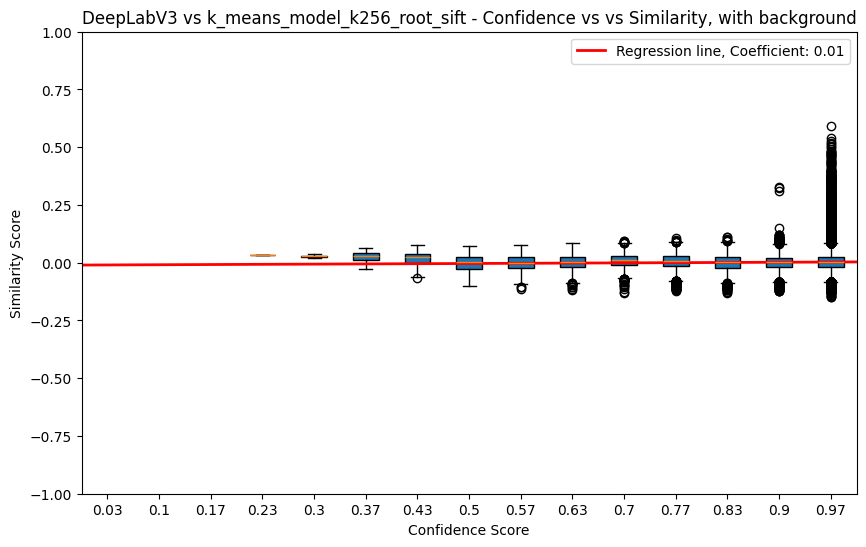

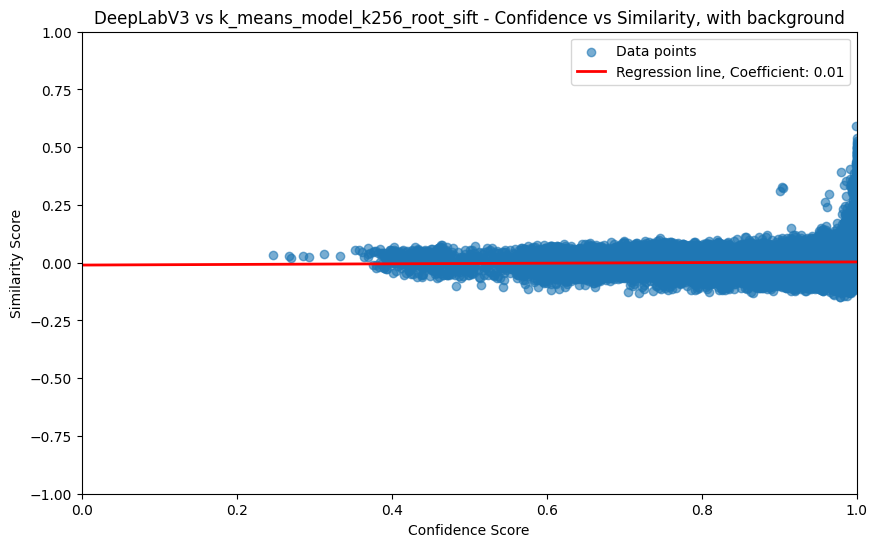

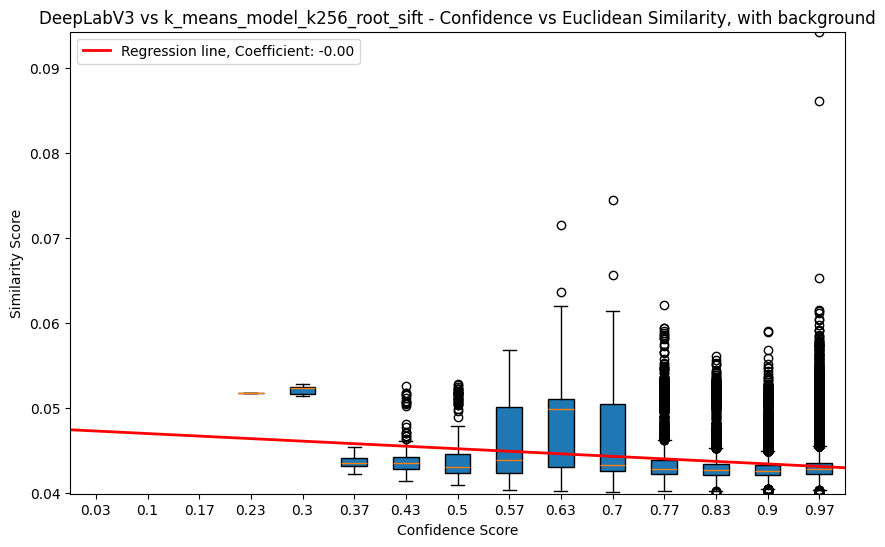

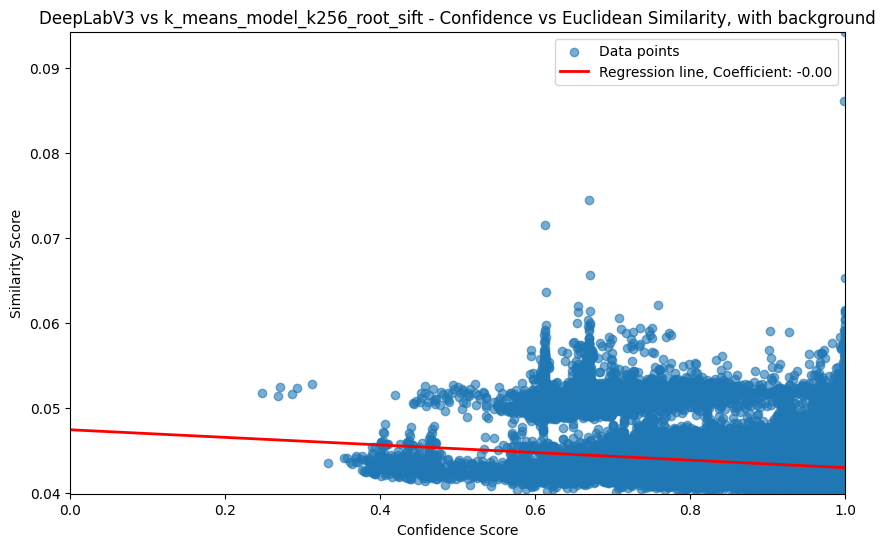

Processing DeepLabV3 vs k_means_model_k64_sift: 100%|██████████| 1782/1782 [03:52<00:00,  7.67it/s]


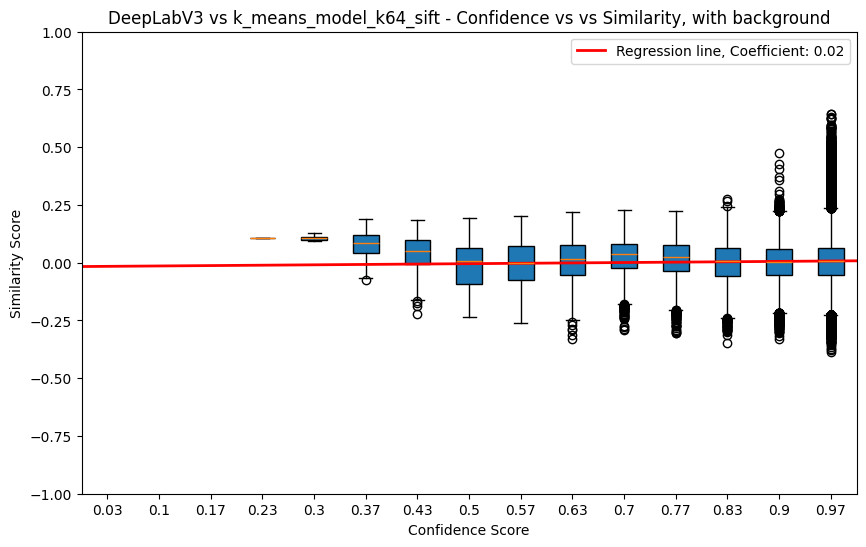

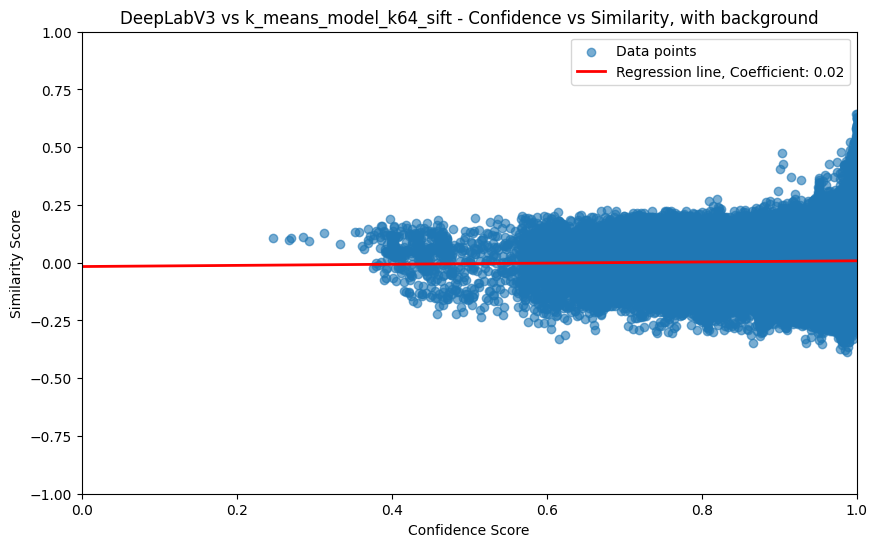

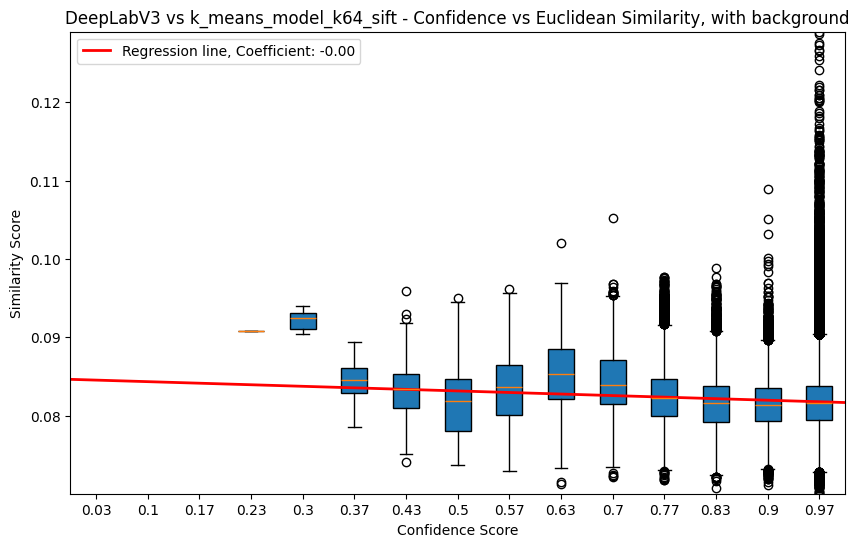

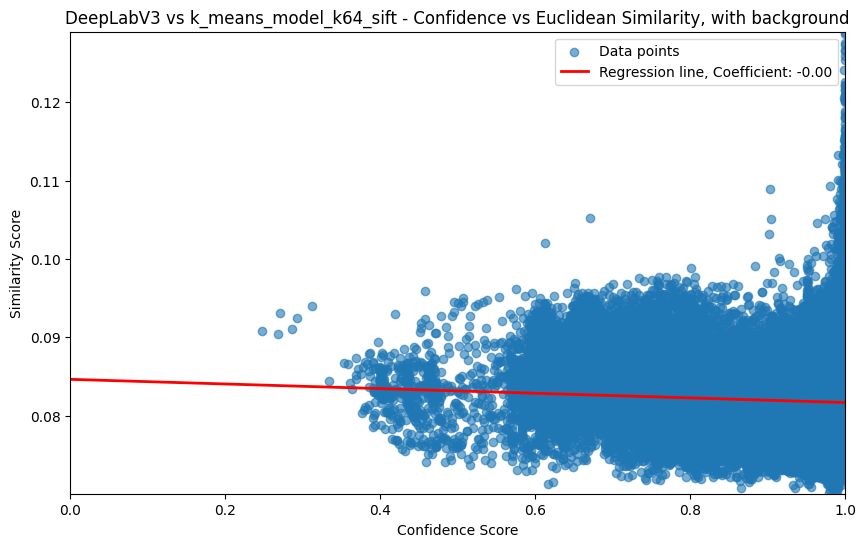

Processing DeepLabV3 vs k_means_model_k16_root_sift: 100%|██████████| 1782/1782 [03:38<00:00,  8.15it/s]


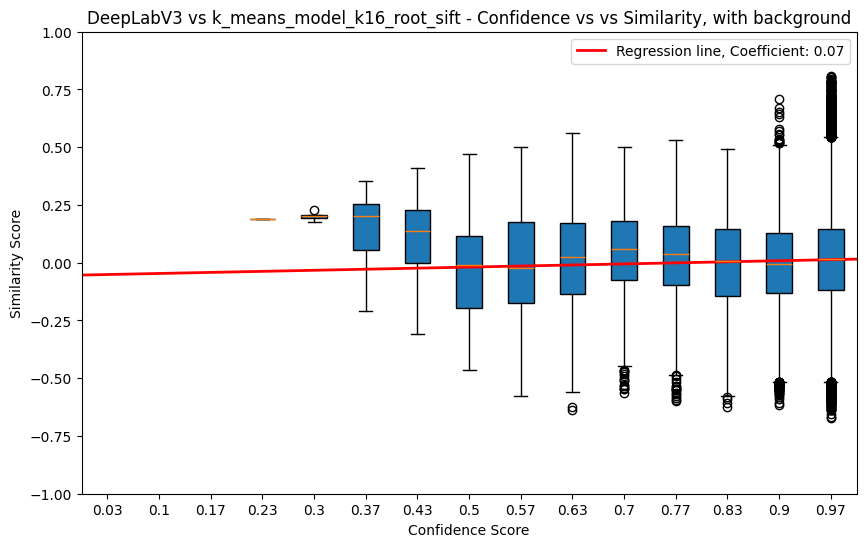

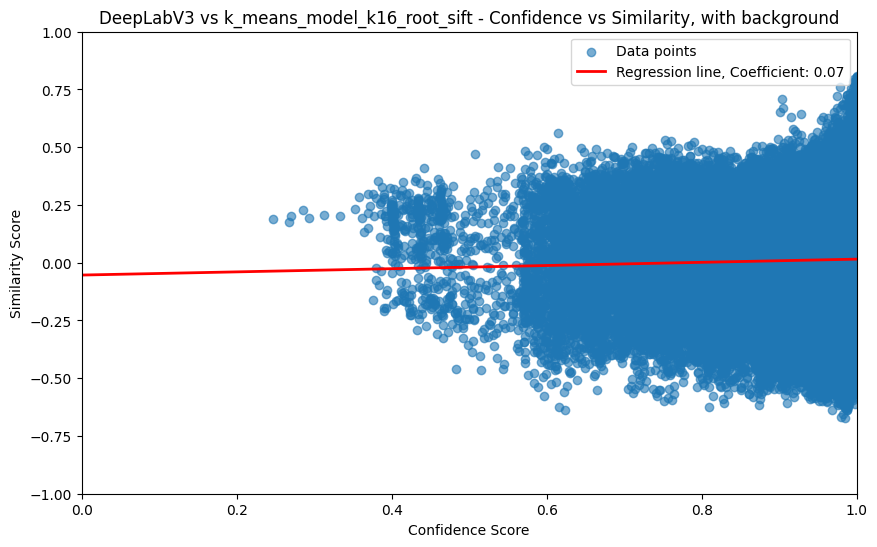

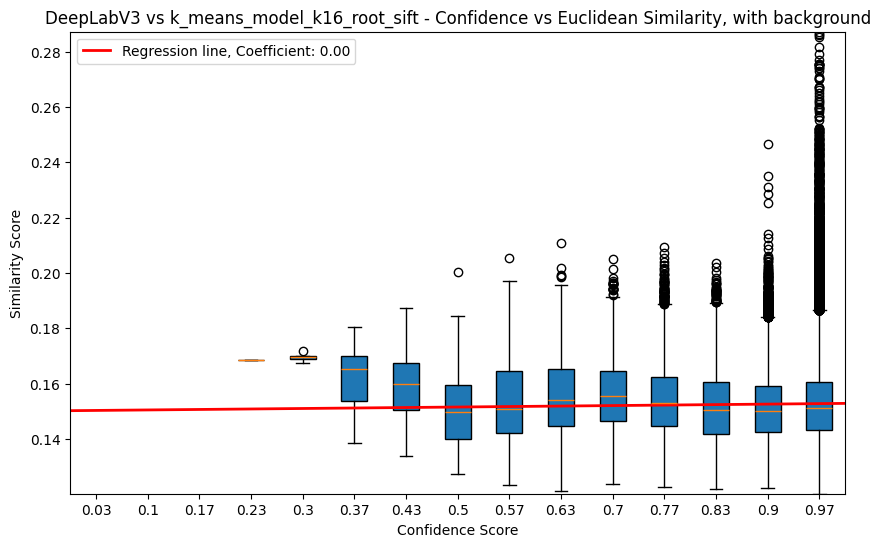

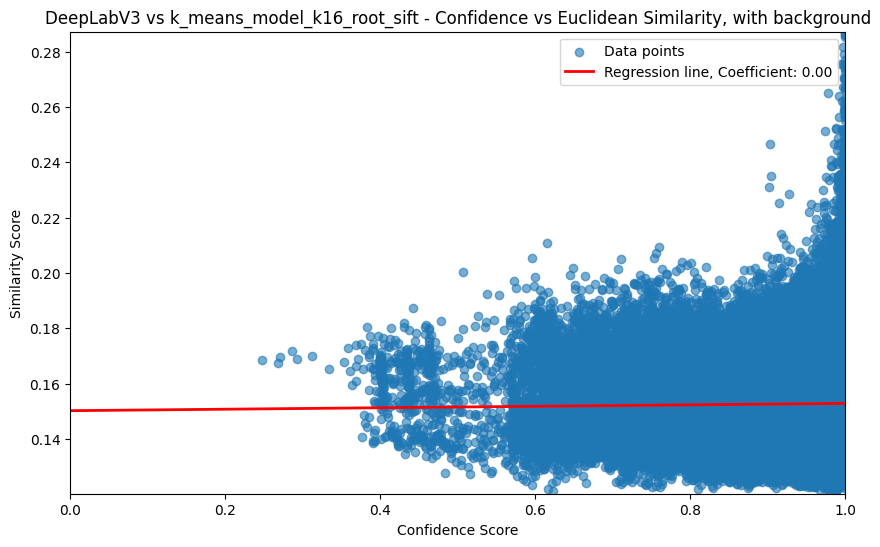

Processing DeepLabV3 vs k_means_model_k32_sift: 100%|██████████| 1782/1782 [03:42<00:00,  8.01it/s]


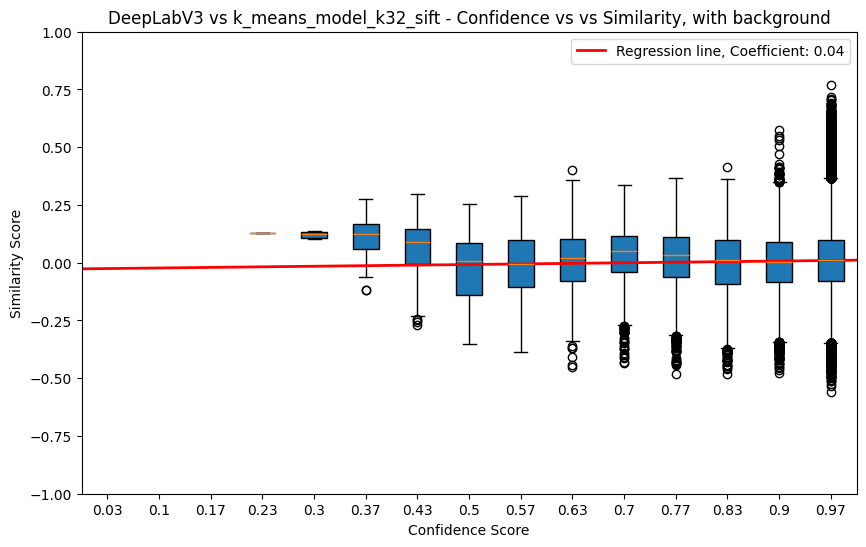

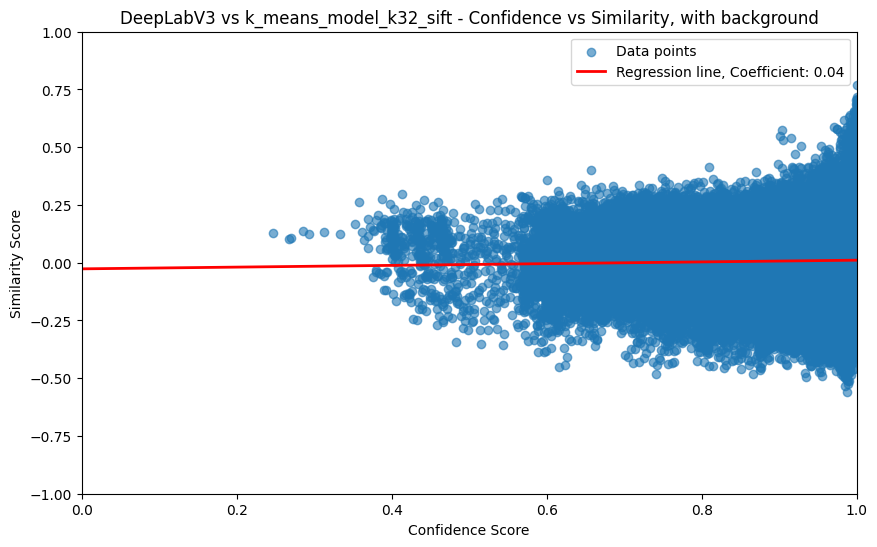

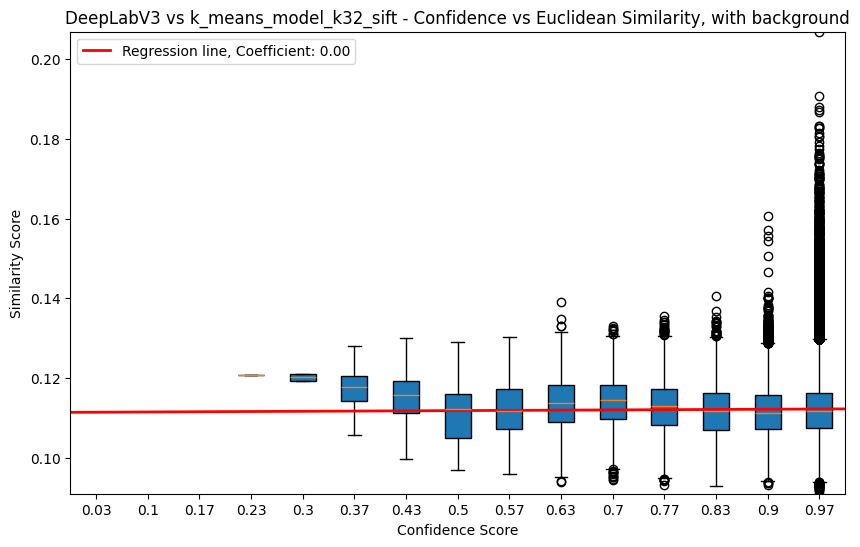

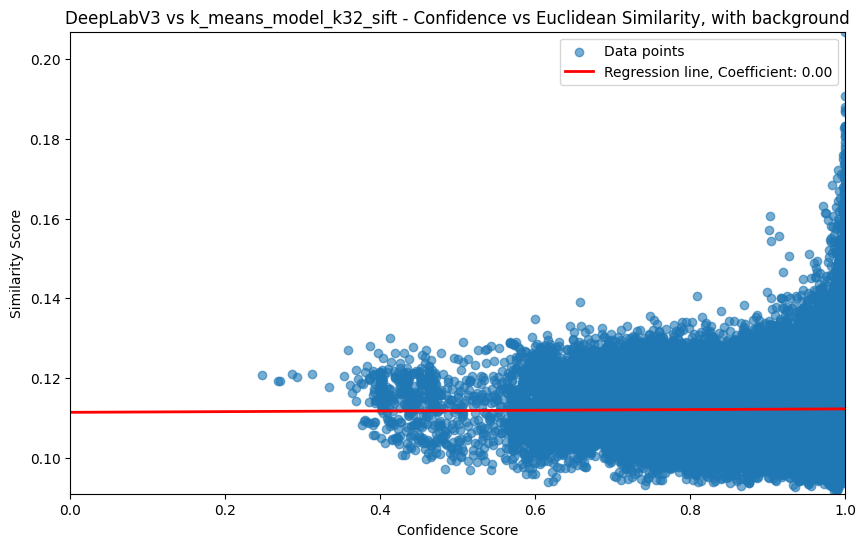

Processing DeepLabV3 vs k_means_model_k16_sift: 100%|██████████| 1782/1782 [03:36<00:00,  8.21it/s]


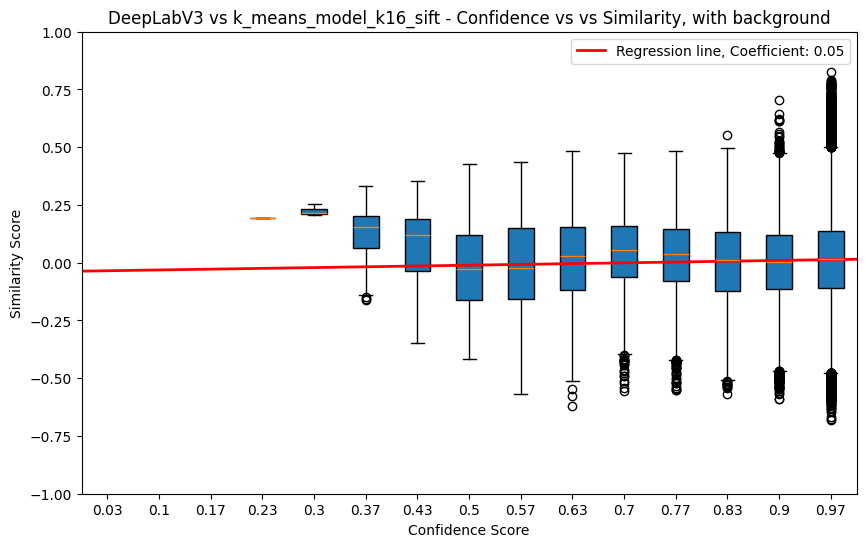

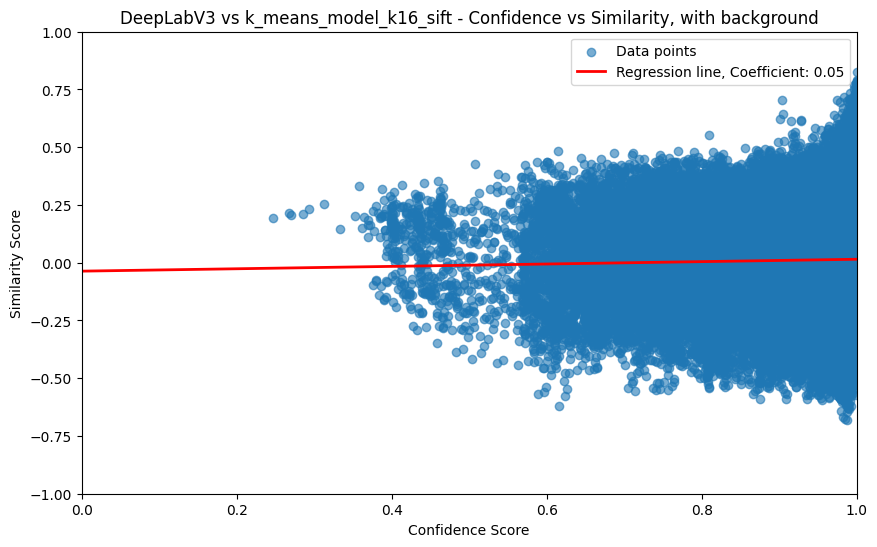

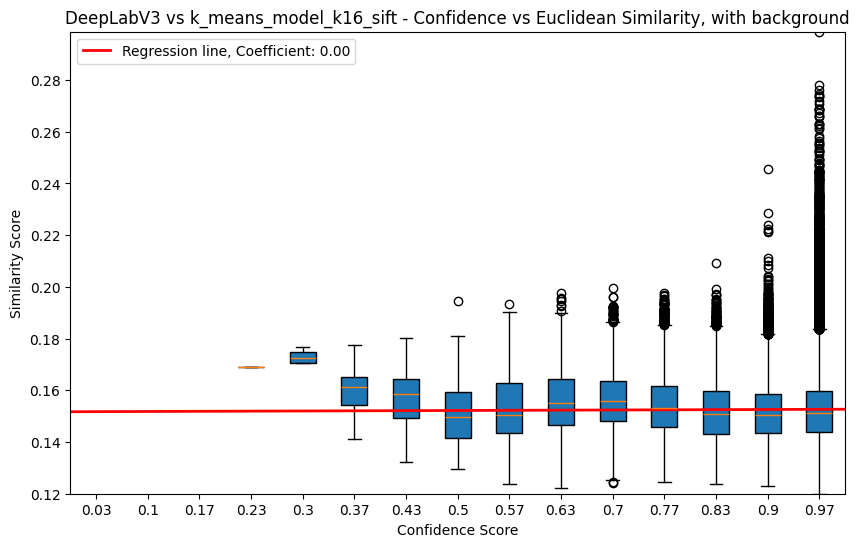

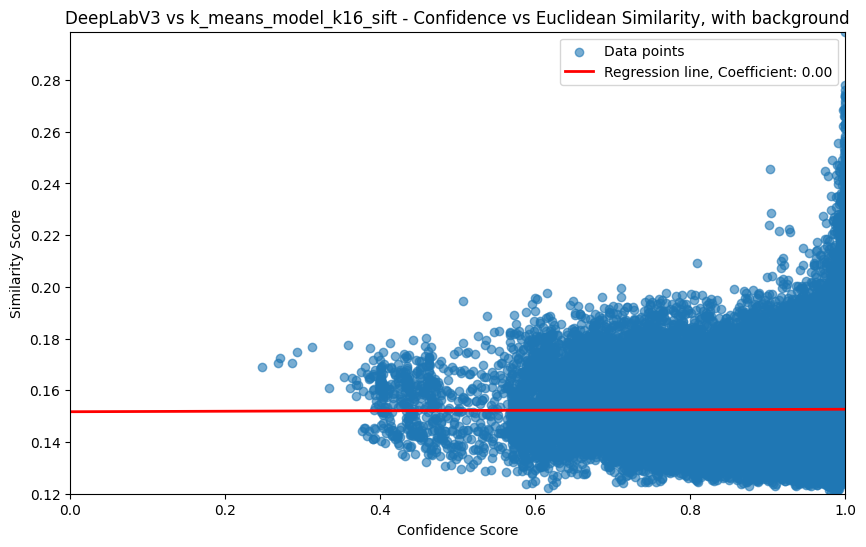

Processing DeepLabV3 vs k_means_model_k32_root_sift: 100%|██████████| 1782/1782 [03:39<00:00,  8.11it/s]


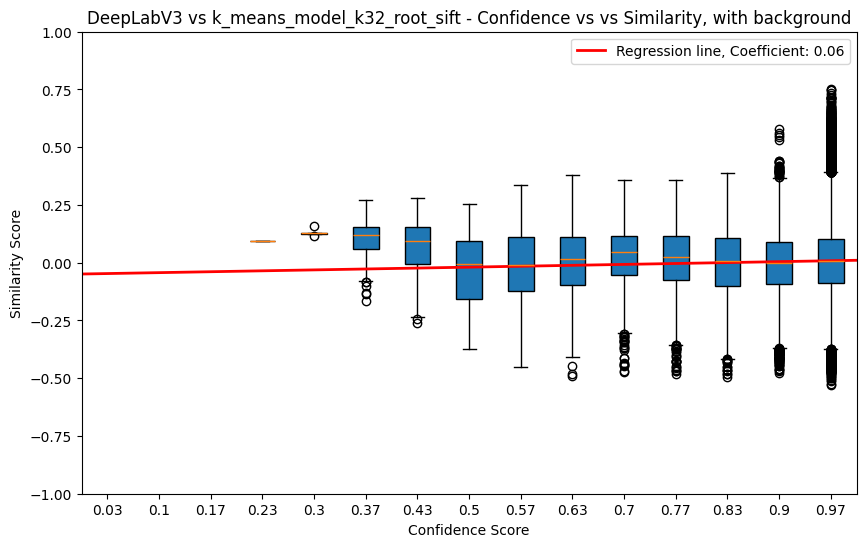

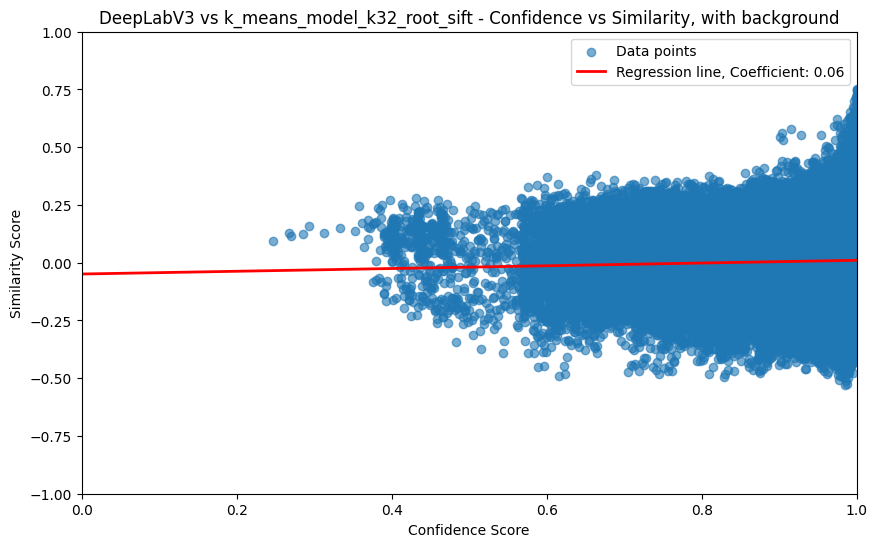

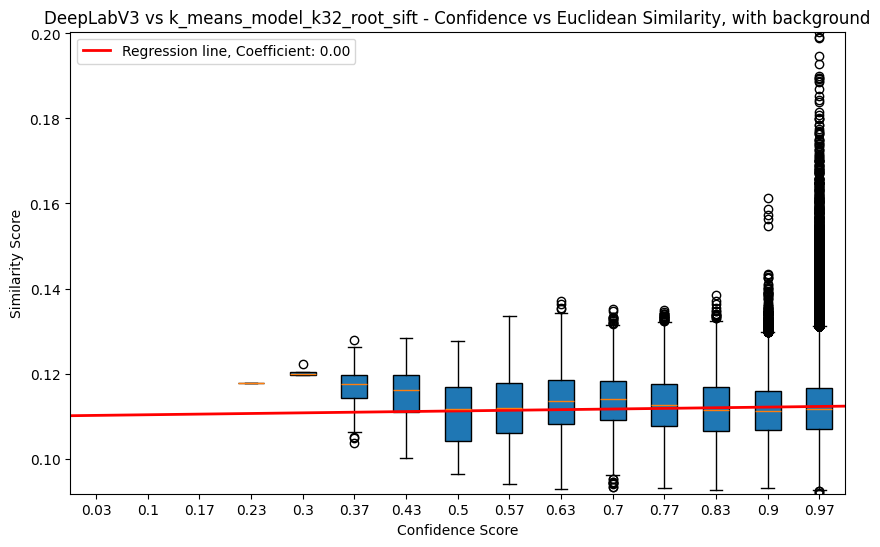

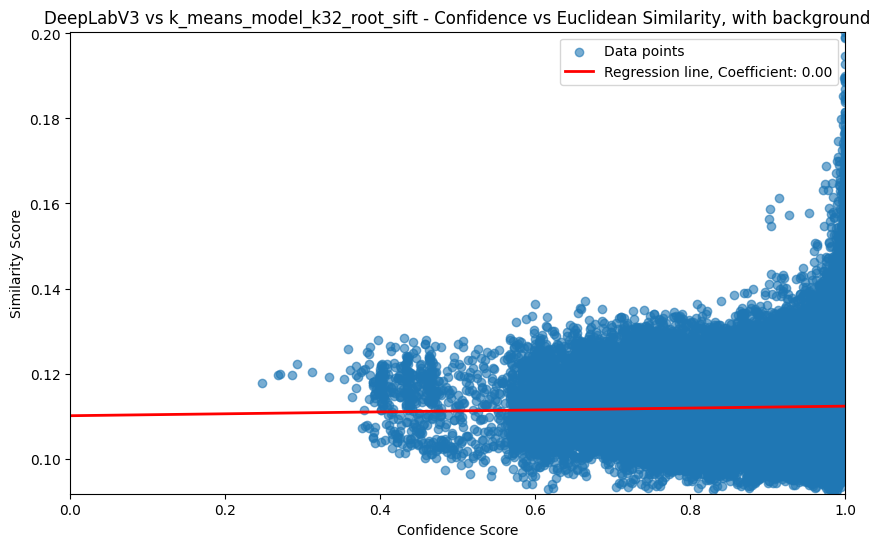

Processing DeepLabV3 vs k_means_model_k256_sift: 100%|██████████| 1782/1782 [38:57<00:00,  1.31s/it] 


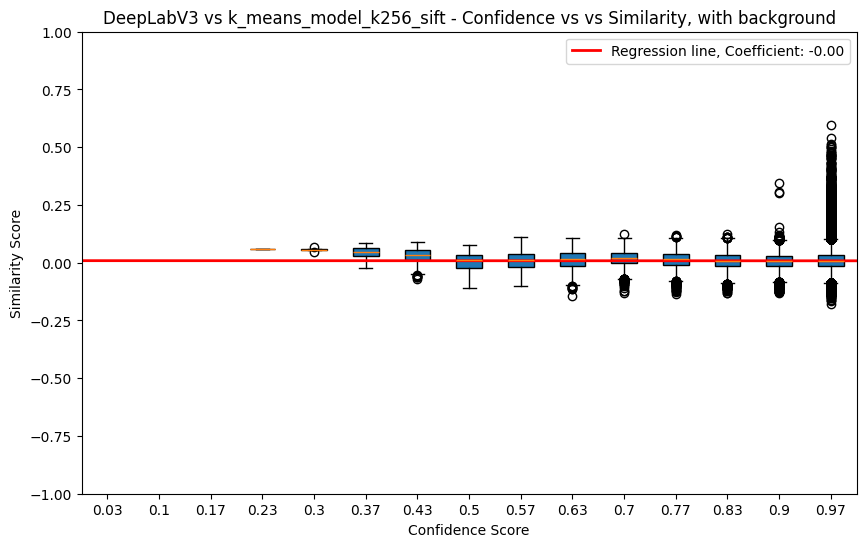

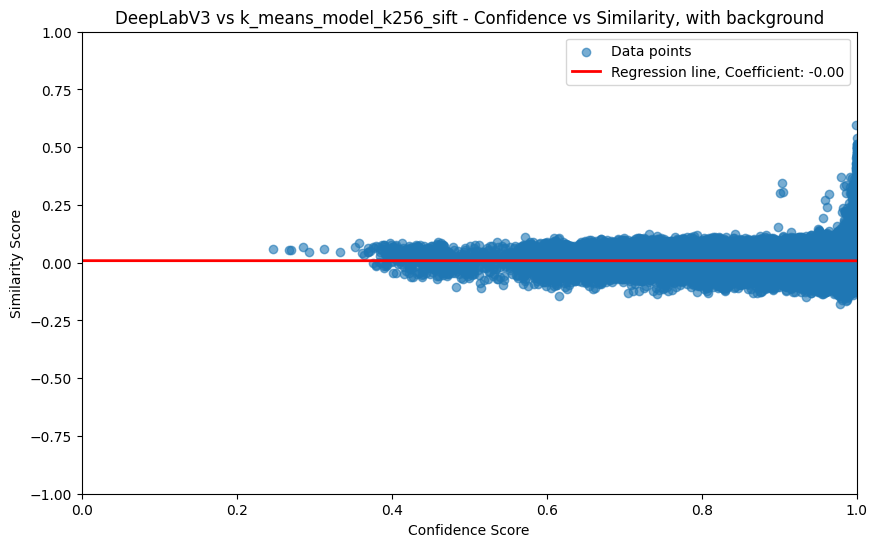

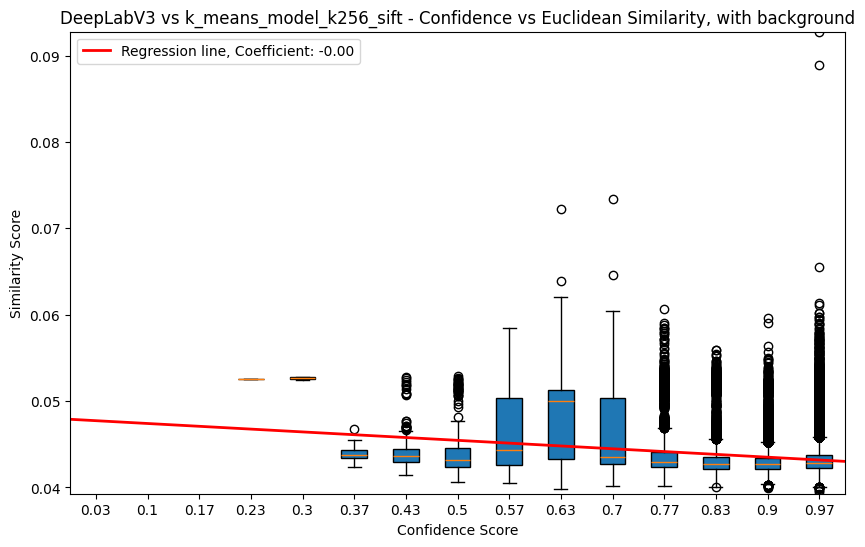

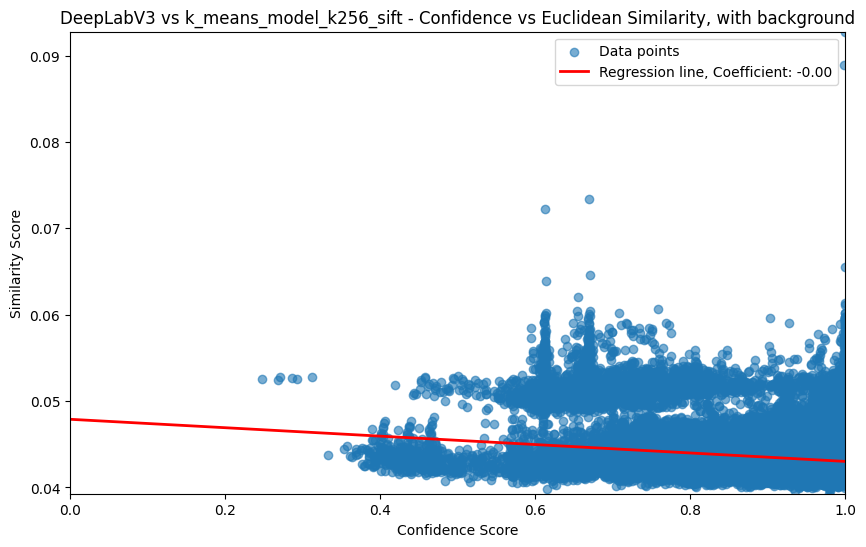

Processing DeepLabV3 vs k_means_model_k64_root_sift: 100%|██████████| 1782/1782 [03:57<00:00,  7.49it/s]


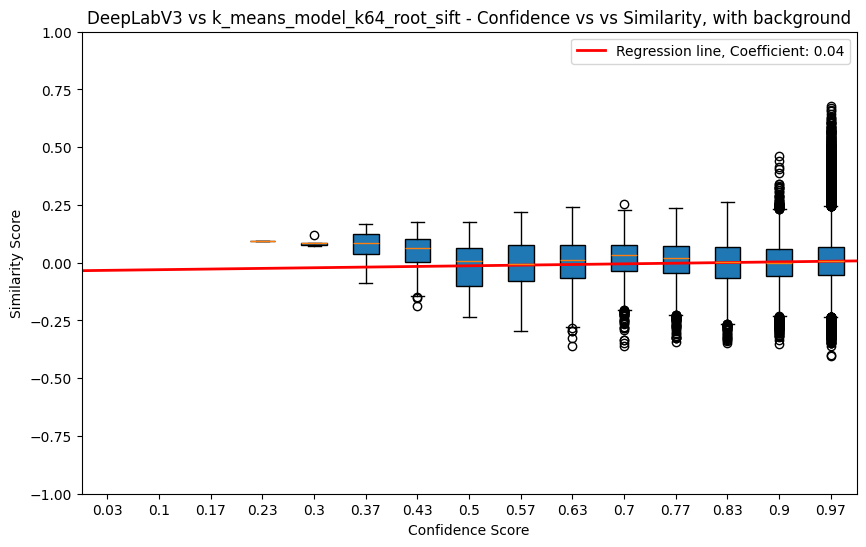

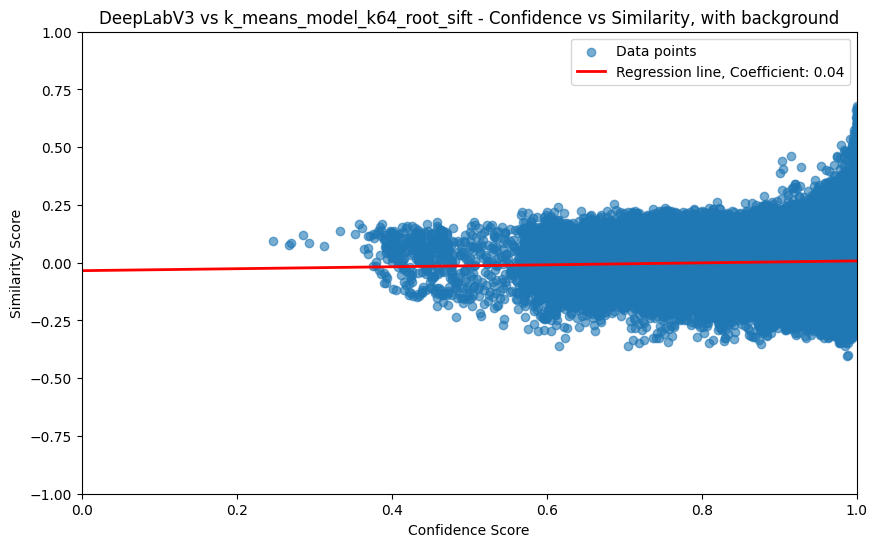

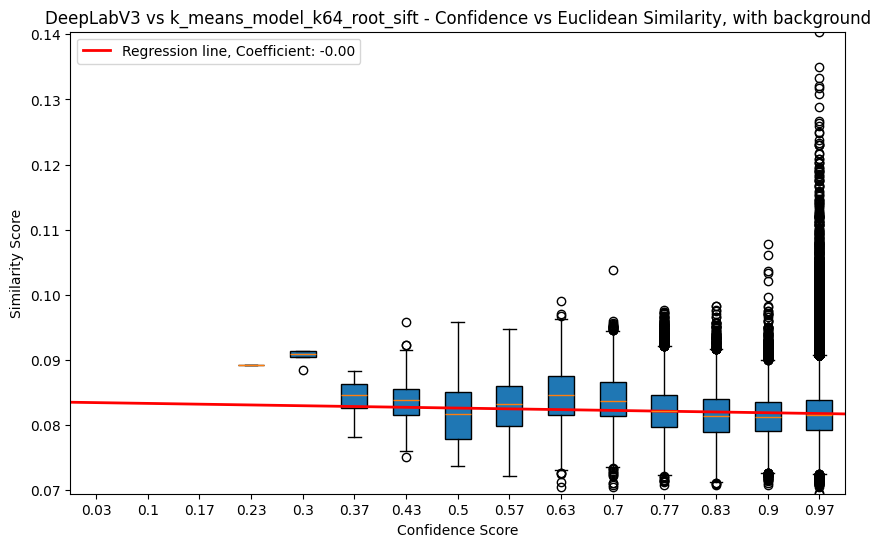

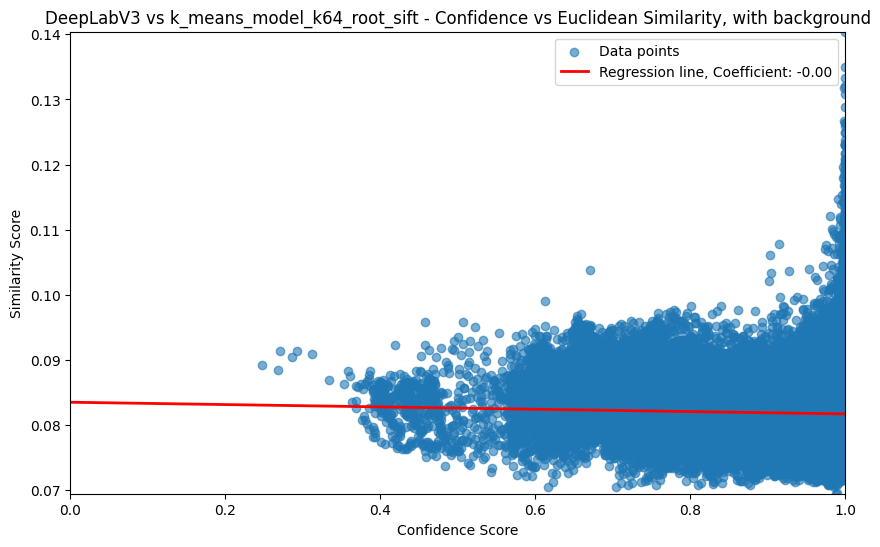

Processing DeepLabV3 vs k_means_model_k128_sift: 100%|██████████| 1782/1782 [33:26<00:00,  1.13s/it]


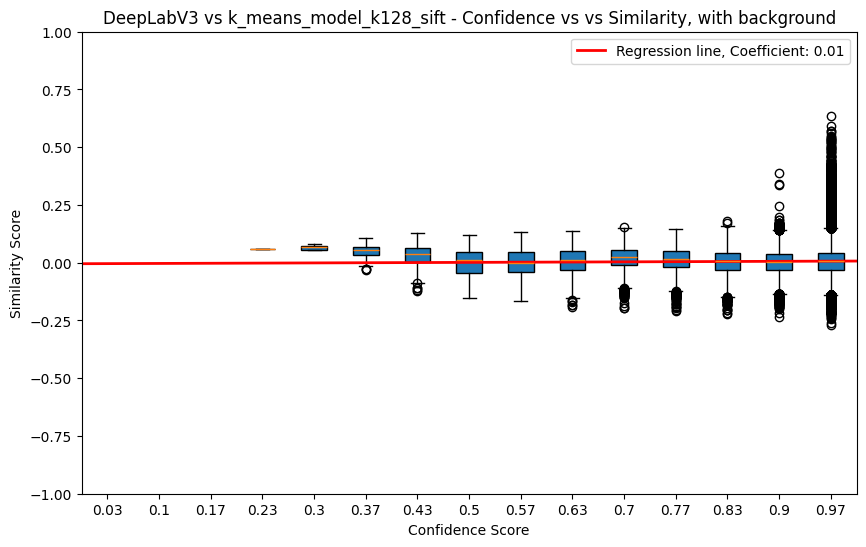

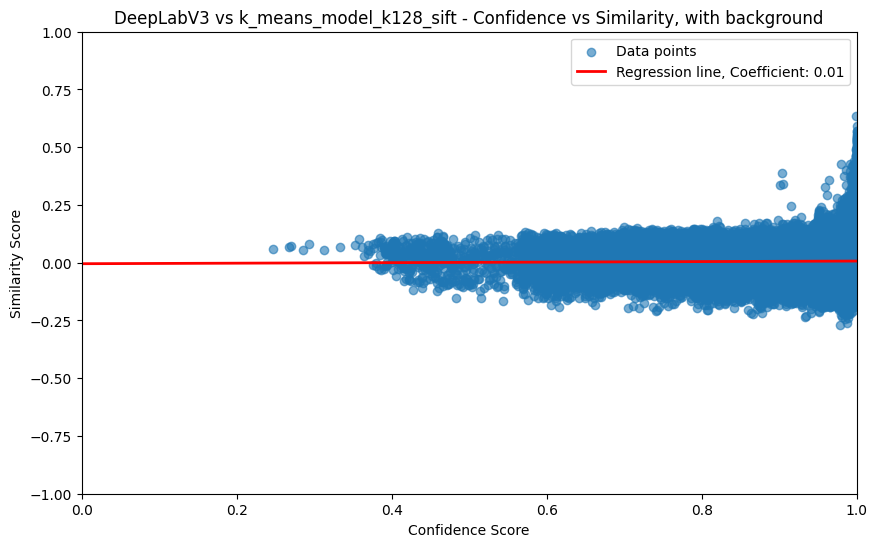

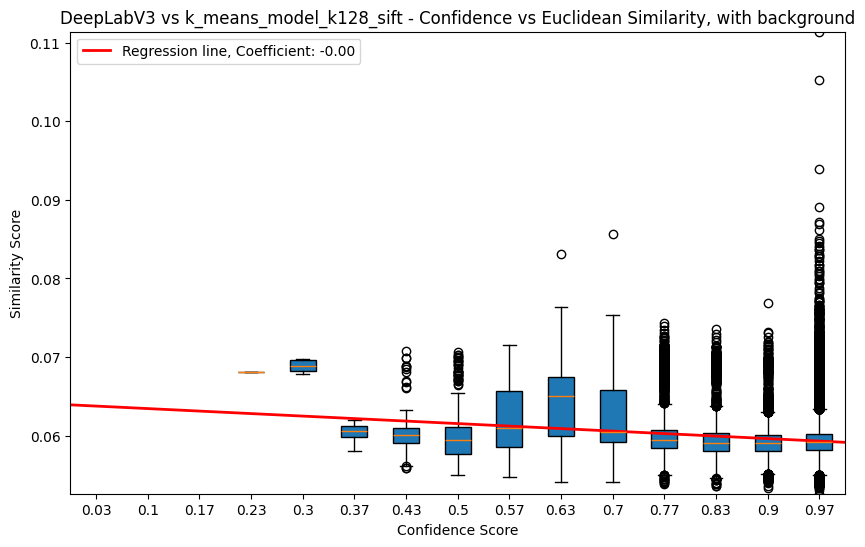

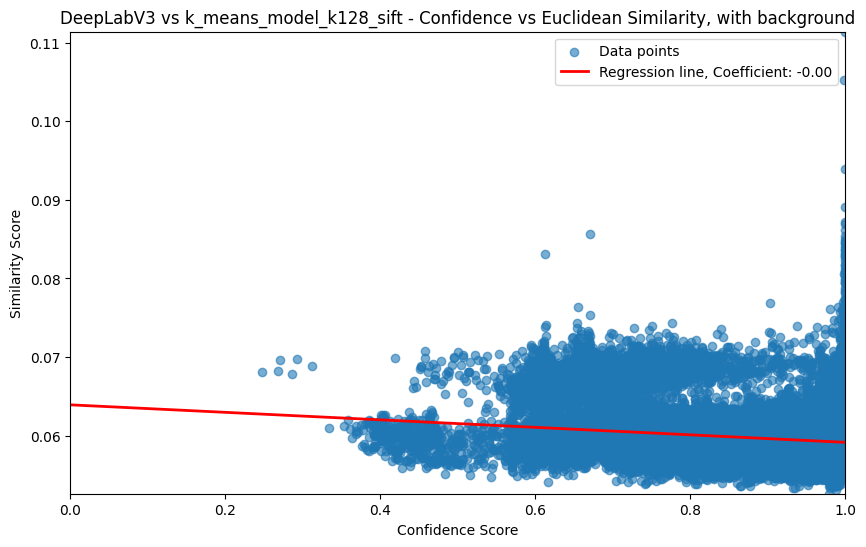

Processing DeepLabV3 vs k_means_model_k24_root_sift: 100%|██████████| 1782/1782 [03:37<00:00,  8.19it/s]


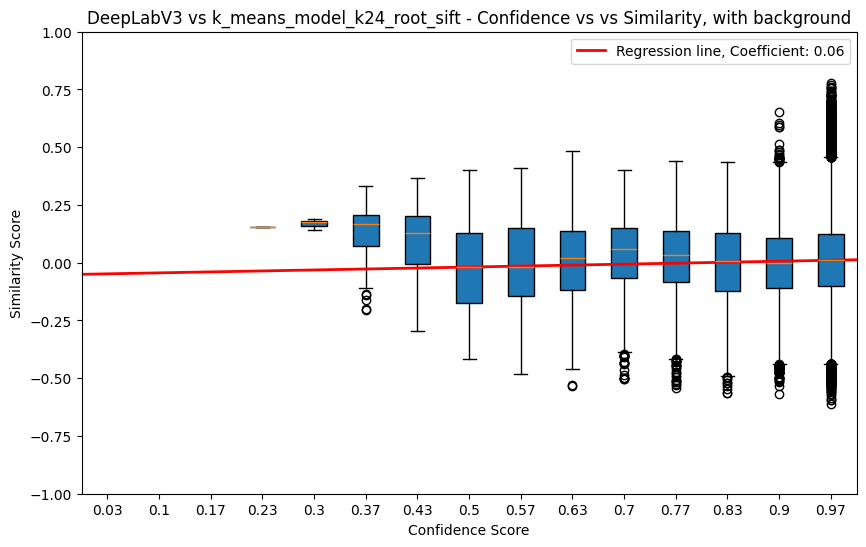

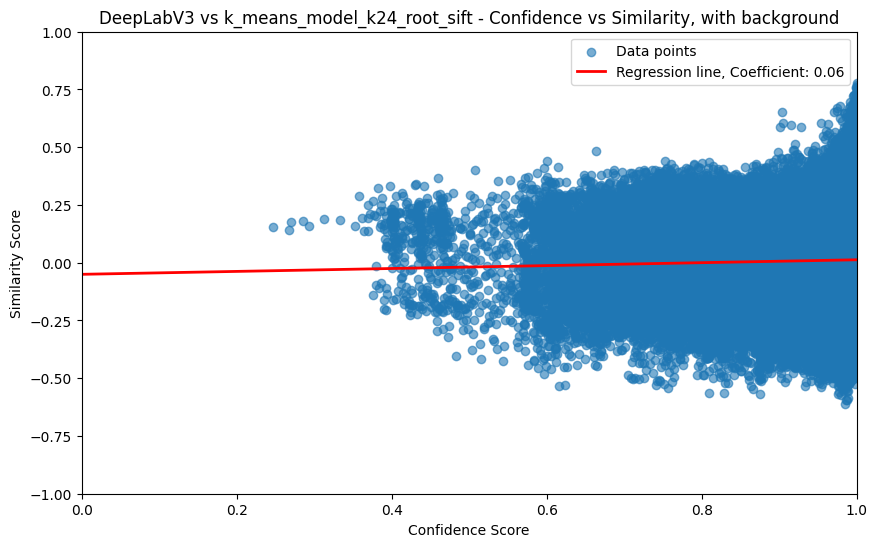

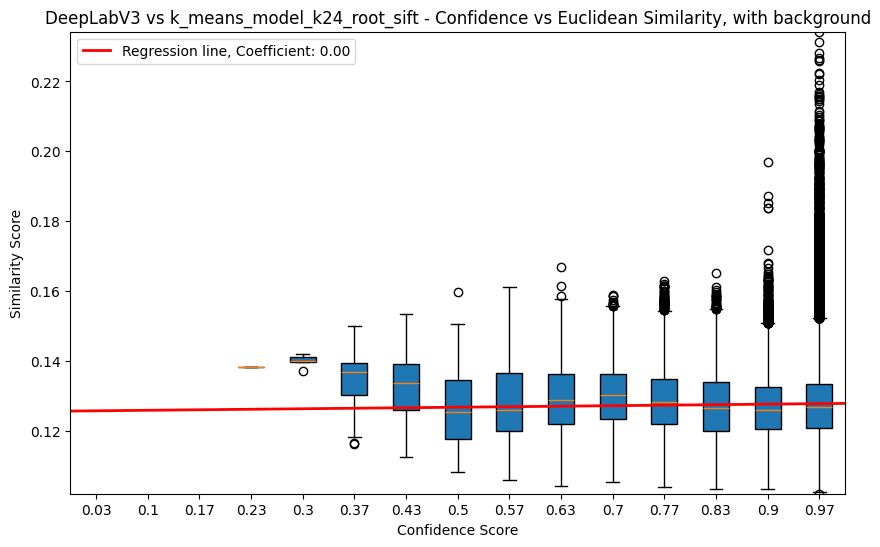

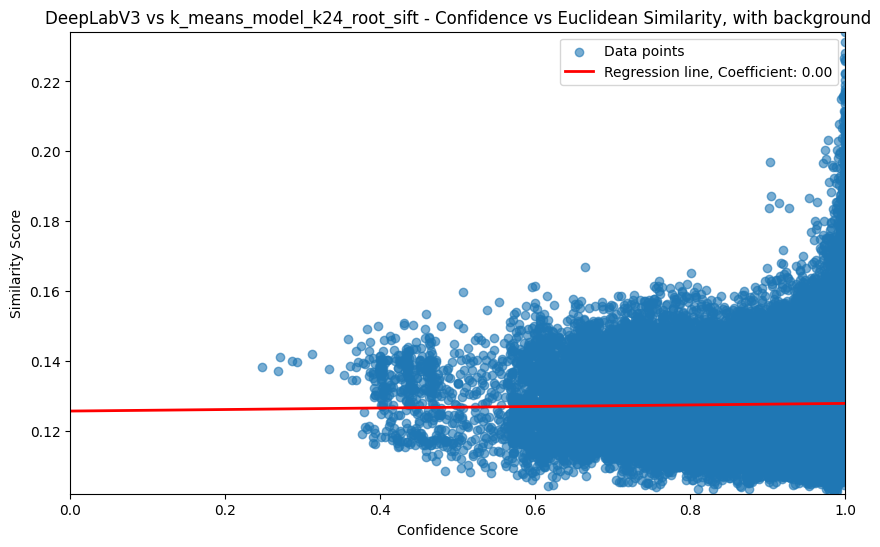

Processing DeepLabV3 vs k_means_model_k128_root_sift: 100%|██████████| 1782/1782 [33:17<00:00,  1.12s/it]


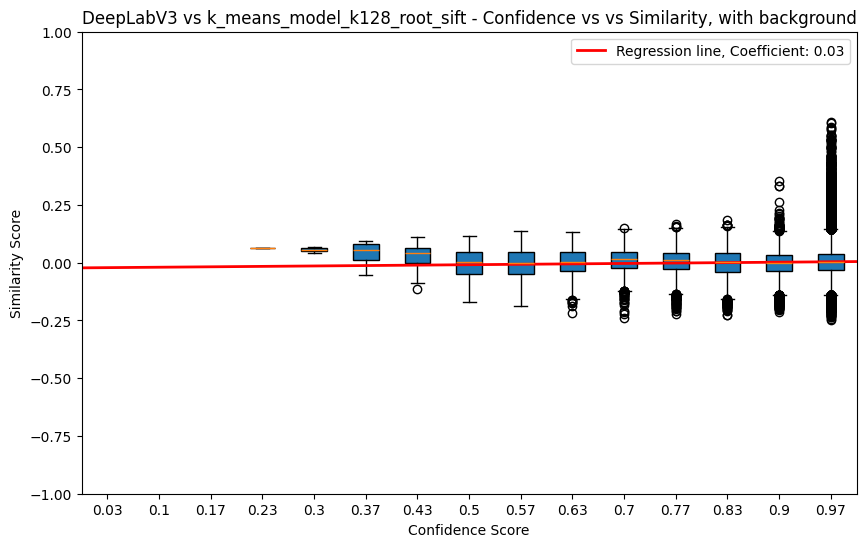

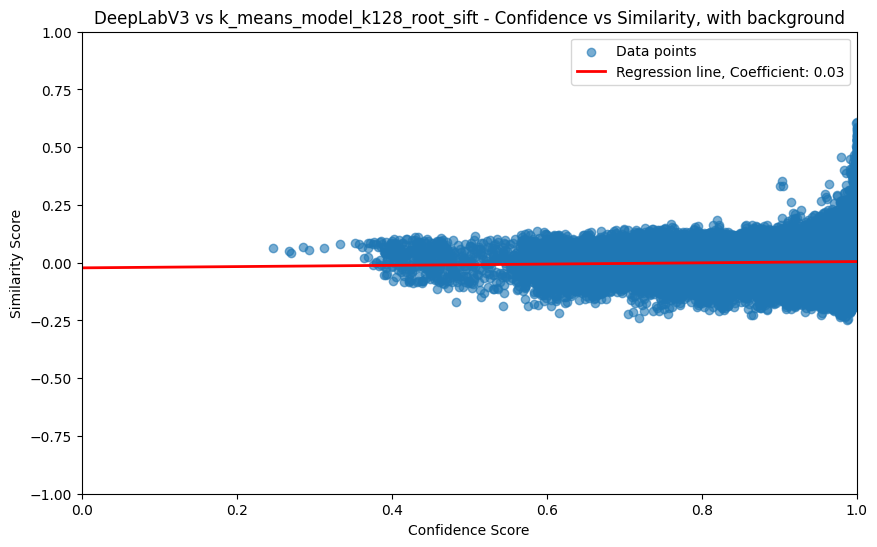

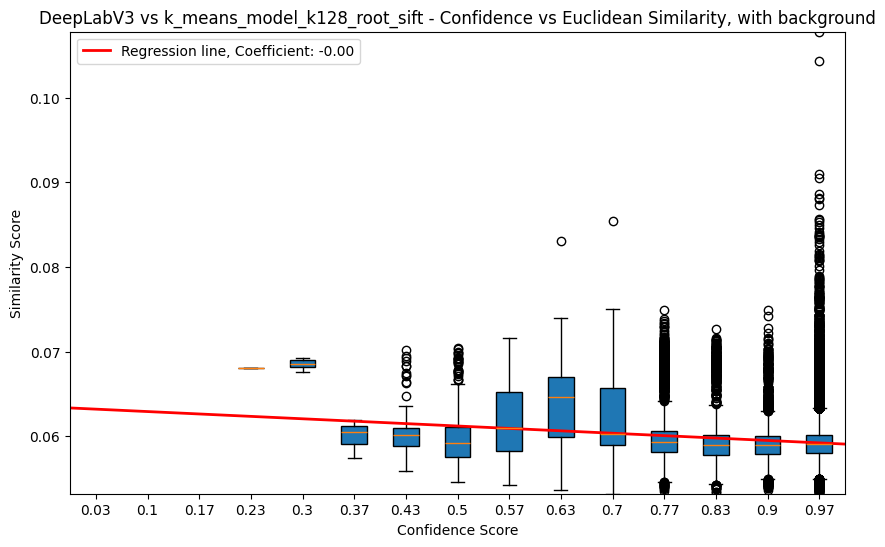

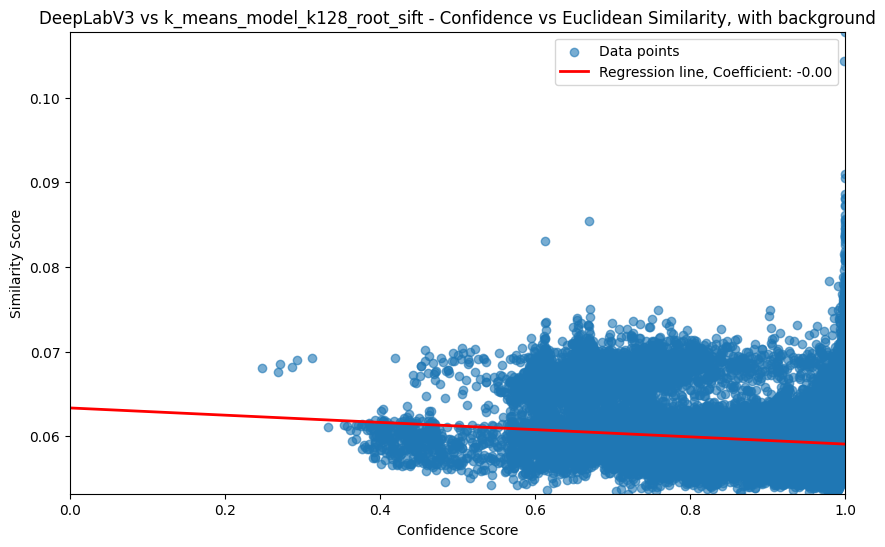

Processing DeepLabV3 vs k_means_model_k24_sift: 100%|██████████| 1782/1782 [03:36<00:00,  8.24it/s]


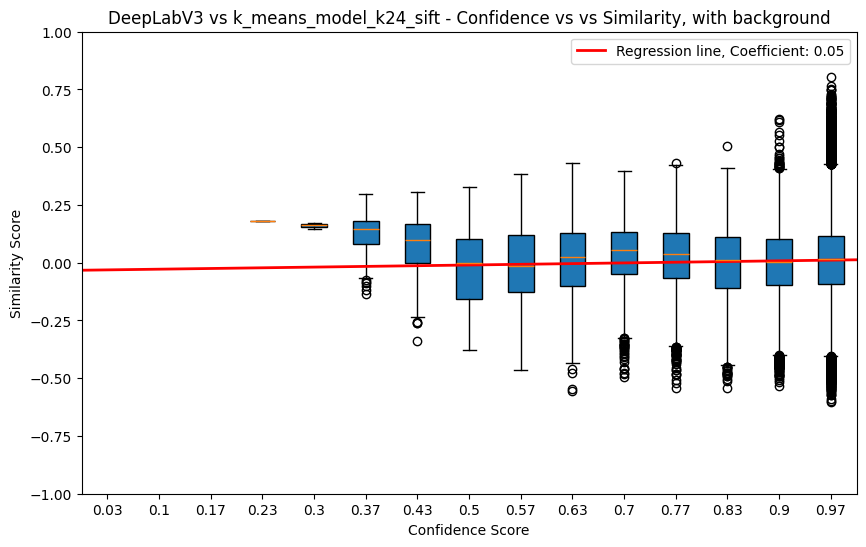

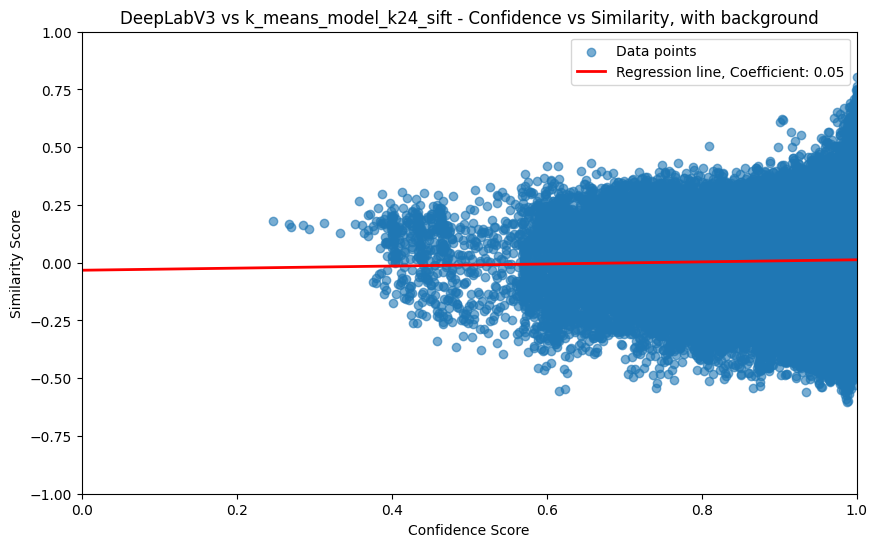

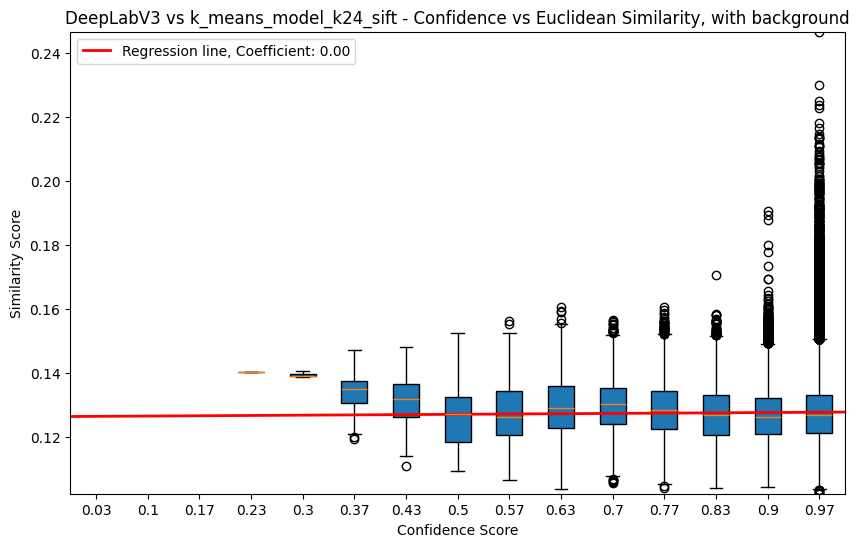

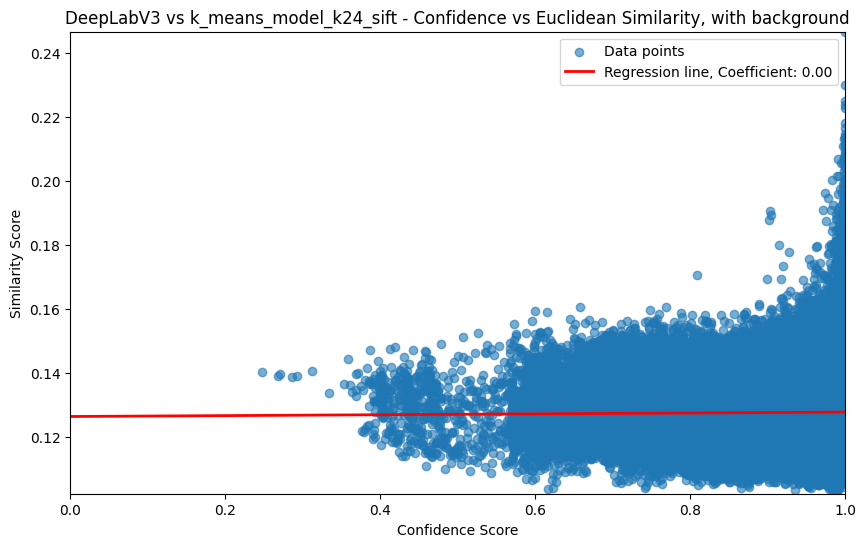

Processing DeepLabV3Plus vs k_means_model_k256_root_sift:  73%|███████▎  | 1297/1782 [48:14<55:31,  6.87s/it]  

In [ ]:
for seg_models in confidence_paths:
    model_name = seg_models.model.__class__.__name__
    conf_train = load_hdf5(confidence_paths[seg_models]['with_background']['train'])
    conf_val = load_hdf5(confidence_paths[seg_models]['with_background']['val'])
    for model in k_means_models:
        k_model = model.replace('.pkl', '')
        similarity_scores = []
        euclidean_similarity = []
        conf_similarity = []
        train_vlad_data = load_hdf5(f'{ROOT}/res/vlad/train/{model[:-4]}.h5')
        val_vlad_data = load_hdf5(f'{ROOT}/res/vlad/validation/{model[:-4]}.h5')
        for train_path in tqdm(train_paths, desc=f"Processing {model_name} vs {k_model}"):
            for val_path in test_paths:
                vlad_1 = train_vlad_data[train_path]
                vlad_2 = val_vlad_data[val_path]
                similarity_scores.append(cosine_similarity([vlad_1], [vlad_2])[0][0])
                euclidean_similarity.append(1.0 / (1.0 + euclidean_distances([vlad_1], [vlad_2])[0][0]))
                conf_train_img = conf_train[train_path]
                conf_val_img = conf_val[val_path]
                conf_similarity.append(cosine_similarity([conf_train_img], [conf_val_img])[0][0])
        plot_boxplot_with_regression(y=np.array(similarity_scores),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} vs {k_model} - Confidence vs vs Similarity, with background",
                                     y_label="Similarity Score",
                                     x_label="Confidence Score",
                                     save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_conf_with_bg_vs_similarity.png")
        plot_scatter_with_regression(y=np.array(similarity_scores),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} vs {k_model} - Confidence vs Similarity, with background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_conf_with_bg_vs_similarity_scatter.png")
        plot_boxplot_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        num_bins=15,
                                        title=f"{model_name} vs {k_model} - Confidence vs Euclidean Similarity, with background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_conf_with_bg_vs_euclidean_similarity.png")
        plot_scatter_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        title=f"{model_name} vs {k_model} - Confidence vs Euclidean Similarity, with background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_conf_with_bg_vs_euclidean_similarity_scatter.png")

### b2) Without Background

In [ ]:
for seg_models in confidence_paths:
    model_name = seg_models.model.__class__.__name__
    conf_train = load_hdf5(confidence_paths[seg_models]['no_background']['train'])
    conf_val = load_hdf5(confidence_paths[seg_models]['no_background']['val'])
    for model in k_means_models:
        k_model = model.replace('.pkl', '')
        similarity_scores = []
        euclidean_similarity = []
        conf_similarity = []
        train_vlad_data = load_hdf5(f'{ROOT}/res/vlad/train/{model[:-4]}.h5')
        val_vlad_data = load_hdf5(f'{ROOT}/res/vlad/validation/{model[:-4]}.h5')
        for train_path in tqdm(train_paths, desc=f"Processing {model_name} vs {k_model}"):
            for val_path in test_paths:
                vlad_1 = train_vlad_data[train_path]
                vlad_2 = val_vlad_data[val_path]
                similarity_scores.append(cosine_similarity([vlad_1], [vlad_2])[0][0])
                euclidean_similarity.append(1.0 / (1.0 + euclidean_distances([vlad_1], [vlad_2])[0][0]))
                conf_train_img = conf_train[train_path]
                conf_val_img = conf_val[val_path]
                conf_similarity.append(cosine_similarity([conf_train_img], [conf_val_img])[0][0])
        plot_boxplot_with_regression(y=np.array(similarity_scores),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} vs {k_model} - Confidence vs vs Similarity, without background",
                                     y_label="Similarity Score",
                                     x_label="Confidence Score",
                                     save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_conf_no_bg_vs_similarity.png")
        plot_scatter_with_regression(y=np.array(similarity_scores),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} vs {k_model} - Confidence vs Similarity, without background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_conf_no_bg_vs_similarity_scatter.png")
        plot_boxplot_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        num_bins=15,
                                        title=f"{model_name} vs {k_model} - Confidence vs Euclidean Similarity, without background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_conf_no_bg_vs_euclidean_similarity.png")
        plot_scatter_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        title=f"{model_name} vs {k_model} - Confidence vs Euclidean Similarity, without background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/vlad/{model_name}_{k_model}_conf_no_bg_vs_euclidean_similarity_scatter.png")

Processing DeepLabV3 vs k_means_model_k256_root_sift:   0%|          | 5/1782 [00:02<15:31,  1.91it/s]

# 2. Fisher Vector

In [ ]:
gmm_models = [
    model for model in os.listdir(rf'{ROOT}/models/pickle_model_files') if 'gmm' in model
]

## a) IoU diff vs Similarity

In [ ]:



for seg_models in confidence_paths:
    model_name = seg_models.model.__class__.__name__
    iou_train = load_hdf5(iou_paths[seg_models]['train'])
    iou_val = load_hdf5(iou_paths[seg_models]['val'])
    for model in gmm_models:
        g_model = model.replace('.pkl', '')
        similarity_scores = []
        euclidean_similarity = []
        iou_diff = []
        train_fisher_data = load_hdf5(f'{ROOT}/res/fisher/train/{model[:-4]}.h5')
        val_fisher_data = load_hdf5(f'{ROOT}/res/fisher/validation/{model[:-4]}.h5')
        for train_path in tqdm(train_paths, desc=f"Processing {model_name} vs {g_model}"):
            for val_path in test_paths:
                fisher_1 = train_fisher_data[train_path]
                fisher_2 = val_fisher_data[val_path]
                similarity_scores.append(cosine_similarity([fisher_1], [fisher_2])[0][0])
                euclidean_similarity.append(1.0 / (1.0 + euclidean_distances([fisher_1], [fisher_2])[0][0]))
                iou_train_img = iou_train[train_path]
                iou_val_img = iou_val[val_path]
                iou_diff.append(abs(iou_train_img - iou_val_img))
        plot_boxplot_with_regression(y=np.array(similarity_scores),
                                     x=np.array(iou_diff),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} vs {g_model} - IoU diff vs Similarity",
                                     y_label="Similarity Score",
                                     x_label="IoU Difference",
                                     save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_iou_vs_similarity.png")
        plot_scatter_with_regression(y=np.array(similarity_scores),
                                     x=np.array(iou_diff),
                                     x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} vs {g_model} - IoU diff vs Similarity",
                                        y_label="Similarity Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_iou_vs_similarity_scatter.png")
        plot_boxplot_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(iou_diff),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        num_bins=15,
                                        title=f"{model_name} vs {g_model} - IoU diff vs Euclidean Similarity",
                                        y_label="Similarity Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_iou_vs_euclidean_similarity.png")
        plot_scatter_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(iou_diff),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        title=f"{model_name} vs {g_model} - IoU diff vs Euclidean Similarity",
                                        y_label="Similarity Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_iou_vs_euclidean_similarity_scatter.png")




## b) Confidence Score vs Similarity

### b1) With Background

In [5]:
for seg_models in confidence_paths:
    model_name = seg_models.model.__class__.__name__
    conf_train = load_hdf5(confidence_paths[seg_models]['with_background']['train'])
    conf_val = load_hdf5(confidence_paths[seg_models]['with_background']['val'])
    for model in gmm_models:
        g_model = model.replace('.pkl', '')
        similarity_scores = []
        euclidean_similarity = []
        conf_similarity = []
        train_fisher_data = load_hdf5(f'{ROOT}/res/fisher/train/{model[:-4]}.h5')
        val_fisher_data = load_hdf5(f'{ROOT}/res/fisher/validation/{model[:-4]}.h5')
        for train_path in tqdm(train_paths, desc=f"Processing {model_name} vs {g_model}"):
            for val_path in test_paths:
                fisher_1 = train_fisher_data[train_path]
                fisher_2 = val_fisher_data[val_path]
                similarity_scores.append(cosine_similarity([fisher_1], [fisher_2])[0][0])
                euclidean_similarity.append(1.0 / (1.0 + euclidean_distances([fisher_1], [fisher_2])[0][0]))
                conf_train_img = conf_train[train_path]
                conf_val_img = conf_val[val_path]
                conf_similarity.append(cosine_similarity([conf_train_img], [conf_val_img])[0][0])
        plot_boxplot_with_regression(y=np.array(similarity_scores),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} vs {g_model} - Confidence vs vs Similarity, with background",
                                     y_label="Similarity Score",
                                     x_label="Confidence Score",
                                     save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_conf_with_bg_vs_similarity.png")
        plot_scatter_with_regression(y=np.array(similarity_scores),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} vs {g_model} - Confidence vs Similarity, with background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_conf_with_bg_vs_similarity_scatter.png")
        plot_boxplot_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        num_bins=15,
                                        title=f"{model_name} vs {g_model} - Confidence vs Euclidean Similarity, with background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_conf_with_bg_vs_euclidean_similarity.png")
        plot_scatter_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        title=f"{model_name} vs {g_model} - Confidence vs Euclidean Similarity, with background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_conf_with_bg_vs_euclidean_similarity_scatter.png")


NameError: name 'gmm_models' is not defined

### b2) Without Background

In [ ]:
for seg_models in confidence_paths:
    model_name = seg_models.model.__class__.__name__
    conf_train = load_hdf5(confidence_paths[seg_models]['no_background']['train'])
    conf_val = load_hdf5(confidence_paths[seg_models]['no_background']['val'])
    for model in gmm_models:
        g_model = model.replace('.pkl', '')
        similarity_scores = []
        euclidean_similarity = []
        conf_similarity = []
        train_fisher_data = load_hdf5(f'{ROOT}/res/fisher/train/{model[:-4]}.h5')
        val_fisher_data = load_hdf5(f'{ROOT}/res/fisher/validation/{model[:-4]}.h5')
        for train_path in tqdm(train_paths, desc=f"Processing {model_name} vs {g_model}"):
            for val_path in test_paths:
                fisher_1 = train_fisher_data[train_path]
                fisher_2 = val_fisher_data[val_path]
                similarity_scores.append(cosine_similarity([fisher_1], [fisher_2])[0][0])
                euclidean_similarity.append(1.0 / (1.0 + euclidean_distances([fisher_1], [fisher_2])[0][0]))
                conf_train_img = conf_train[train_path]
                conf_val_img = conf_val[val_path]
                conf_similarity.append(cosine_similarity([conf_train_img], [conf_val_img])[0][0])
        plot_boxplot_with_regression(y=np.array(similarity_scores),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} vs {g_model} - Confidence vs vs Similarity, without background",
                                     y_label="Similarity Score",
                                     x_label="Confidence Score",
                                     save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_conf_no_bg_vs_similarity.png")
        plot_scatter_with_regression(y=np.array(similarity_scores),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} vs {g_model} - Confidence vs Similarity, without background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_conf_no_bg_vs_similarity_scatter.png")
        plot_boxplot_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        num_bins=15,
                                        title=f"{model_name} vs {g_model} - Confidence vs Euclidean Similarity, without background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_conf_no_bg_vs_euclidean_similarity.png")
        plot_scatter_with_regression(y=np.array(euclidean_similarity),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(min(euclidean_similarity), max(euclidean_similarity)),
                                        title=f"{model_name} vs {g_model} - Confidence vs Euclidean Similarity, without background",
                                        y_label="Similarity Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/fisher/{model_name}_{g_model}_conf_no_bg_vs_euclidean_similarity_scatter.png")

# 3. SSIM + MS-SSIM

## a) IoU diff vs SSIM

In [21]:
for seg_models in iou_paths:
    model_name = seg_models.model.__class__.__name__
    iou_train = load_hdf5(iou_paths[seg_models]['train'])
    iou_val = load_hdf5(iou_paths[seg_models]['val'])
    for gaussian_sigmas in range(0, 10, 2):
        ssim_data = load_hdf5(f'{ROOT}/res/ssim/train_vs_val/ssim_train_val_sigma{gaussian_sigmas}.h5')
        ssim_scores = []
        ms_ssim_scores = []
        mssim_scores = []
        iou_diff = []

        for train_img, *_, train_path in train_dataset_transformed:
            for val_img, *_, val_path in enumerate(val_dataset_transformed):
                key = f'{os.path.basename(train_path)}@@{os.path.basename(val_path)}'
                ssim_scores.append(ssim_data[key]['ssim'])
                ms_ssim_scores.append(ssim_data[key]['ms_ssim'])
                iou_train_img = iou_train[os.path.basename(train_path)]
                iou_val_img = iou_val[os.path.basename(val_path)]
                iou_diff.append(abs(iou_train_img - iou_val_img))
        plot_boxplot_with_regression(y=np.array(ssim),
                                     x=np.array(iou_diff),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} - IoU diff vs MS-SSIM",
                                     y_label="MS-SSIM Score",
                                     x_label="IoU Difference",
                                     save_fig_path=f"{ROOT}/res/plots/mssim/{model_name}_iou_vs_mssim.png")
        plot_scatter_with_regression(y=np.array(mssim_scores),
                                        x=np.array(iou_diff),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} - IoU diff vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/ms_sim/{model_name}_iou_vs_mssim_scatter.png")
        plot_boxplot_with_regression(y=np.array(ms_ssim_scores),
                                        x=np.array(iou_diff),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        num_bins=15,
                                        title=f"{model_name} - IoU diff vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/mssim/{model_name}_iou_vs_mssim.png")
        plot_scatter_with_regression(y=np.array(ms_ssim_scores),
                                        x=np.array(iou_diff),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} - IoU diff vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/ms_sim/{model_name}_iou_vs_mssim_scatter.png")


KeyboardInterrupt: 

## b) Confidence Score vs SSIM

### b1) With Background

In [ ]:
for seg_models in confidence_paths:
    model_name = seg_models.model.__class__.__name__
    conf_train = load_hdf5(confidence_paths[seg_models]['with_background']['train'])
    conf_val = load_hdf5(confidence_paths[seg_models]['with_background']['val'])
    for gaussian_sigmas in range(0, 10, 2):
        ssim_data = load_hdf5(f'{ROOT}/res/ssim/train_vs_val/ssim_train_val_sigma{gaussian_sigmas}.h5')
        ssim_scores = []
        ms_ssim_scores = []
        mssim_scores = []
        conf_similarity = []

        for train_img, *_, train_path in train_dataset_transformed:
            for val_img, *_, val_path in enumerate(val_dataset_transformed):
                key = f'{os.path.basename(train_path)}@@{os.path.basename(val_path)}'
                ssim_scores.append(ssim_data[key]['ssim'])
                ms_ssim_scores.append(ssim_data[key]['ms_ssim'])
                conf_train_img = conf_train[os.path.basename(train_path)]
                conf_val_img = conf_val[os.path.basename(val_path)]
                conf_similarity.append(cosine_similarity([conf_train_img], [conf_val_img])[0][0])
        plot_boxplot_with_regression(y=np.array(ssim),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} - Confidence vs MS-SSIM",
                                     y_label="MS-SSIM Score",
                                     x_label="Confidence Score",
                                     save_fig_path=f"{ROOT}/res/plots/mssim/{model_name}_conf_vs_mssim.png")
        plot_scatter_with_regression(y=np.array(mssim_scores),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} - Confidence vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/ms_sim/{model_name}_conf_vs_mssim_scatter.png")
        plot_boxplot_with_regression(y=np.array(ms_ssim_scores),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        num_bins=15,
                                        title=f"{model_name} - Confidence vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/mssim/{model_name}_conf_vs_mssim.png")
        plot_scatter_with_regression(y=np.array(ms_ssim_scores),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} - Confidence vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/ms_sim/{model_name}_conf_vs_mssim_scatter.png")

### b2) Without Background

In [ ]:
for seg_models in confidence_paths:
    model_name = seg_models.model.__class__.__name__
    conf_train = load_hdf5(confidence_paths[seg_models]['no_background']['train'])
    conf_val = load_hdf5(confidence_paths[seg_models]['no_background']['val'])
    for gaussian_sigmas in range(0, 10, 2):
        ssim_data = load_hdf5(f'{ROOT}/res/ssim/train_vs_val/ssim_train_val_sigma{gaussian_sigmas}.h5')
        ssim_scores = []
        ms_ssim_scores = []
        mssim_scores = []
        conf_similarity = []

        for train_img, *_, train_path in train_dataset_transformed:
            for val_img, *_, val_path in enumerate(val_dataset_transformed):
                key = f'{os.path.basename(train_path)}@@{os.path.basename(val_path)}'
                ssim_scores.append(ssim_data[key]['ssim'])
                ms_ssim_scores.append(ssim_data[key]['ms_ssim'])
                conf_train_img = conf_train[os.path.basename(train_path)]
                conf_val_img = conf_val[os.path.basename(val_path)]
                conf_similarity.append(cosine_similarity([conf_train_img], [conf_val_img])[0][0])
        plot_boxplot_with_regression(y=np.array(ssim),
                                     x=np.array(conf_similarity),
                                     x_lim=(0, 1),
                                     y_lim=(-1, 1),
                                     num_bins=15,
                                     title=f"{model_name} - Confidence vs MS-SSIM",
                                     y_label="MS-SSIM Score",
                                     x_label="Confidence Score",
                                     save_fig_path=f"{ROOT}/res/plots/mssim/{model_name}_conf_vs_mssim.png")
        plot_scatter_with_regression(y=np.array(mssim_scores),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} - Confidence vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/ms_sim/{model_name}_conf_vs_mssim_scatter.png")
        plot_boxplot_with_regression(y=np.array(ms_ssim_scores),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        num_bins=15,
                                        title=f"{model_name} - Confidence vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/mssim/{model_name}_conf_vs_mssim.png")
        plot_scatter_with_regression(y=np.array(ms_ssim_scores),
                                        x=np.array(conf_similarity),
                                        x_lim=(0, 1),
                                        y_lim=(-1, 1),
                                        title=f"{model_name} - Confidence vs MS-SSIM",
                                        y_label="MS-SSIM Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/ms_sim/{model_name}_conf_vs_mssim_scatter.png")

# 4. Combination: Fisher + MS-SSIM

Arbitrary combination of Fisher Vector and MS-SSIM: gmm_128_root_sift_128.pkl and ssim_train_val_sigma4.h5:
- cosine similarity of fisher vectors are shifted to center around 0.5
- each metric has weight 0.5

## a) IoU diff vs Fisher + MS-SSIM

In [ ]:
gmm_model = 'gmm_128_root_sift_128.pkl'
ssim_file = 'ssim_train_val_sigma4.h5'

for seg_models in iou_paths:
    model_name = seg_models.model.__class__.__name__
    iou_train = load_hdf5(iou_paths[seg_models]['train'])
    iou_val = load_hdf5(iou_paths[seg_models]['val'])
    ssim_data = load_hdf5(f'{ROOT}/res/ssim/train_vs_val/{ssim_file}')
    fisher_data = load_hdf5(f'{ROOT}/res/fisher/train/{gmm_model[:-4]}.h5')
    similarity_scores = []
    iou_diff = []
    for train_path in tqdm(train_paths, desc=f"Processing {model_name} vs {gmm_model}"):
        for val_path in test_paths:
            fisher_1 = fisher_data[train_path]
            fisher_2 = fisher_data[val_path]
            fisher_scores = cosine_similarity([fisher_1], [fisher_2])[0][0]
            fisher_scores = ((fisher_scores + 1) / 2).clip(0, 1)
            key = f'{os.path.basename(train_path)}@@{os.path.basename(val_path)}'
            ms_ssim_scores = ssim_data[key]['ms_ssim'].cpu().numpy()
            similarity_scores.append(0.5 * fisher_scores + 0.5 * ms_ssim_scores)
            iou_train_img = iou_train[os.path.basename(train_path)]
            iou_val_img = iou_val[os.path.basename(val_path)]
            iou_diff.append(abs(iou_train_img - iou_val_img))

    plot_boxplot_with_regression(y=np.array(similarity_scores),
                                 x=np.array(iou_diff),
                                 x_lim=(0, 1),
                                 y_lim=(0, 1),
                                 num_bins=15,
                                 title=f"{model_name} vs {gmm_model} - IoU diff vs Fisher + MS-SSIM",
                                 y_label="Fisher + MS-SSIM Score",
                                 x_label="IoU Difference",
                                 save_fig_path=f"{ROOT}/res/plots/fisher_mssim/{model_name}_{gmm_model}_iou_vs_similarity.png")
    plot_scatter_with_regression(y=np.array(similarity_scores),
                                    x=np.array(iou_diff),
                                    x_lim=(0, 1),
                                        y_lim=(0, 1),
                                        title=f"{model_name} vs {gmm_model} - IoU diff vs Fisher + MS-SSIM",
                                        y_label="Fisher + MS-SSIM Score",
                                        x_label="IoU Difference",
                                        save_fig_path=f"{ROOT}/res/plots/fisher_mssim/{model_name}_{gmm_model}_iou_vs_similarity_scatter.png")

## b) Confidence Score vs Fisher + MS-SSIM

In [ ]:
for seg_models in confidence_paths:
    model_name = seg_models.model.__class__.__name__
    conf_train = load_hdf5(confidence_paths[seg_models]['with_background']['train'])
    conf_val = load_hdf5(confidence_paths[seg_models]['with_background']['val'])
    ssim_data = load_hdf5(f'{ROOT}/res/ssim/train_vs_val/{ssim_file}')
    fisher_data = load_hdf5(f'{ROOT}/res/fisher/train/{gmm_model[:-4]}.h5')
    similarity_scores = []
    conf_similarity = []
    for train_path in tqdm(train_paths, desc=f"Processing {model_name} vs {gmm_model}"):
        for val_path in test_paths:
            fisher_1 = fisher_data[train_path]
            fisher_2 = fisher_data[val_path]
            fisher_scores = cosine_similarity([fisher_1], [fisher_2])[0][0]
            fisher_scores = ((fisher_scores + 1) / 2).clip(0, 1)
            key = f'{os.path.basename(train_path)}@@{os.path.basename(val_path)}'
            ms_ssim_scores = ssim_data[key]['ms_ssim'].cpu().numpy()
            similarity_scores.append(0.5 * fisher_scores + 0.5 * ms_ssim_scores)
            conf_train_img = conf_train[os.path.basename(train_path)]
            conf_val_img = conf_val[os.path.basename(val_path)]
            conf_similarity.append(cosine_similarity([conf_train_img], [conf_val_img])[0][0])
    plot_boxplot_with_regression(y=np.array(similarity_scores),
                                 x=np.array(conf_similarity),
                                 x_lim=(0, 1),
                                 y_lim=(0, 1),
                                 num_bins=15,
                                 title=f"{model_name} vs {gmm_model} - Confidence vs Fisher + MS-SSIM",
                                 y_label="Fisher + MS-SSIM Score",
                                 x_label="Confidence Score",
                                 save_fig_path=f"{ROOT}/res/plots/fisher_mssim/{model_name}_{gmm_model}_conf_with_bg_vs_similarity.png")
    plot_scatter_with_regression(y=np.array(similarity_scores),
                                    x=np.array(conf_similarity),
                                    x_lim=(0, 1),
                                        y_lim=(0, 1),
                                        title=f"{model_name} vs {gmm_model} - Confidence vs Fisher + MS-SSIM",
                                        y_label="Fisher + MS-SSIM Score",
                                        x_label="Confidence Score",
                                        save_fig_path=f"{ROOT}/res/plots/fisher_mssim/{model_name}_{gmm_model}_conf_with_bg_vs_similarity_scatter.png")
